## Индивидуальное домашнее задание №2
# «Исследование цены горнолыжных курортов»
 Горячева, Князева, Пластинина, Николина

## 1. Сбор и предобработка данных
Для выполнения анализа был использован набор данных (актуальный на 2022 год) с платформы Kaggle, содержащий следующие числовые переменные: \

*Price* — стоимость отдыха (в евро на день на одного взрослого), \
*Highest point* — высота самой высокой точки курорта (в м), \
*Beginner slopes* — длина трасс для новичков (в км), \
*Intermediate slopes* — длина трасс средней сложности (в км), \
*Difficult slopes* — длина сложных трасс (в км), \
*Total slopes* — общая длина трасс (в км), \
*Longest run* — длина самой длинной трассы на курорте (в км), \
*Snow cannons* — количество снежных пушек, \
*Surface lifts* — количество бугельных подъемников, \
*Chair lifts* — количество кресельных подъемников, \
*Gondola lifts* — количество гондольных подъемников, \
*Total lifts* — общее количество подъемников на курорте, \
*Lift capacity* — суммарная пропускная способность подъемников (чел/час), \
*GDP* — ВВП региона, где находится курорт (в условных единицах), \
*Rating* — рейтинг курорта (в баллах).


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from itertools import *
import chardet
import plotly.express as px
import os

In [ ]:
!pip install kaggle
!pip install chardet

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download farheenshaukat/ski-resort
! unzip ski-resort.zip

! kaggle datasets download alejopaullier/-gdp-by-country-1999-2022
os.rename("-gdp-by-country-1999-2022.zip", "gdp-by-country-1999-2022.zip")
! unzip gdp-by-country-1999-2022.zip

! kaggle datasets download fhellander/global-ski-resort-rankings-dataset
! unzip global-ski-resort-rankings-dataset.zip
os.rename("GDP by Country 1999-2022.csv", "GDP.csv")

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/farheenshaukat/ski-resort
License(s): unknown
  0% 0.00/2.79M [00:00<?, ?B/s]
100% 2.79M/2.79M [00:00<00:00, 113MB/s]
Archive:  ski-resort.zip
  inflating: resorts.csv             
  inflating: snow.csv                
Dataset URL: https://www.kaggle.com/datasets/alejopaullier/-gdp-by-country-1999-2022
License(s): CC0-1.0
  0% 0.00/14.8k [00:00<?, ?B/s]
100% 14.8k/14.8k [00:00<00:00, 21.1MB/s]
Archive:  gdp-by-country-1999-2022.zip
  inflating: GDP by Country 1999-2022.csv  
Dataset URL: https://www.kaggle.com/datasets/fhellander/global-ski-resort-rankings-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 62.9MB/s]
Archive:  global-ski-resort-rankings-dataset.zip
  inflating: ski-resorts.csv         


In [ ]:
encoding = 'WINDOWS-1252'
data = pd.read_csv('resorts.csv', encoding=encoding)
# присоединение ВВП
data_country_GPD = pd.read_csv('GDP.csv')
data = data.merge(data_country_GPD[['Country', '2022']], on='Country', how='left')
data.rename(columns={'2022': 'GDP'}, inplace=True)

In [ ]:
data_rate = pd.read_csv('ski-resorts.csv')
data_rate.rename(columns={'name': 'Resort'}, inplace=True)
data_rate.rename(columns={'rating': 'Rating'}, inplace=True)
data_rate.rename(columns={'location_country': 'Country'}, inplace=True)
data_rate.loc[data_rate['Country'] == 'USA', 'Country'] = 'United States'

data["Rating"] = None

In [ ]:
for i, row in data_rate.iterrows():
    resort_name_2 = row["Resort"]
    country_2 = row["Country"]
    rating_2 = row["Rating"]

    first_word = resort_name_2.split()[0]

    matching_rows = data[
        data["Resort"].str.contains(fr"\b{first_word}\b", case=False, na=False) &
        (data["Country"] == country_2)
    ]

    if not matching_rows.empty:
        for idx in matching_rows.index:
            data.at[idx, "Rating"] = rating_2

Предобрабатываем данные

In [ ]:
data = data.dropna(subset=['Rating'])
data = data.dropna(subset=['GDP'])

In [ ]:
df_name = pd.DataFrame()
df_name[['Resort', 'Country']] = data[['Resort', 'Country']]

In [ ]:
data['Rating'] = data['Rating'].astype(float)

data['GDP'] = data['GDP'].str.replace(',', '')
data['GDP'] = pd.to_numeric(data['GDP'], errors='coerce')

In [ ]:
# num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

num_cols = [
#  'ID',
#  'Latitude',
#  'Longitude',
 'Price',
 'Highest point',
#  'Lowest point',
 'Beginner slopes',
 'Intermediate slopes',
 'Difficult slopes',
 'Total slopes',
 'Longest run',
 'Snow cannons',
 'Surface lifts',
 'Chair lifts',
 'Gondola lifts',
 'Total lifts',
 'Lift capacity',
 'GDP',
 'Rating']

In [ ]:
# cat_cols = data.select_dtypes(include=['object']).columns.tolist()
cat_cols = [
#  'Resort',
#  'Country',
 'Child friendly',
 'Snowparks',
 'Season',
 'Nightskiing']

In [ ]:
target_col = 'Price'
all_cols = num_cols + cat_cols
# all_cols

In [ ]:
df = data[all_cols]

In [ ]:
# Child friendly: ['Yes' 'No']
# Snowparks: ['Yes' 'No']
# Nightskiing: ['Yes' 'No']
change_cat_col_bool = ['Child friendly', 'Snowparks', 'Nightskiing']

for col in change_cat_col_bool:
  df[col] = df[col].map({'Yes': 1, 'No': 0})

<ipython-input-14-7ad54f55494b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map({'Yes': 1, 'No': 0})
<ipython-input-14-7ad54f55494b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map({'Yes': 1, 'No': 0})
<ipython-input-14-7ad54f55494b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
df['Season_month'] = 0
df.loc[df['Season'] == 'November - May, June - August', 'Season'] = 'November - August' #10
df.loc[df['Season'] == 'October - November, December - May, June - October', 'Season'] = 'Year - round' #12
df.loc[df['Season'] == 'December - April, June - August, October - November', 'Season'] = 'December - September'#10

season_mode = df['Season'].mode()[0]
df.loc[df['Season'] == 'Unknown', 'Season'] = season_mode
df.loc[df['Season'] == 'Year-round', 'Season'] = 'January - December'
df = df[df['Season'].str.contains('-') & ~df['Season'].str.contains(',')]

month_mapping = {
'January': 1,
'February': 2,
'March': 3,
'April': 4,
'May': 5,
'June': 6,
'July': 7,
'August': 8,
'September': 9,
'October': 10,
'November': 11,
'December': 12 }


# print(df['Season'].value_counts())

df[['Season_start', 'Season_end']] = df['Season'].str.split(' - ', expand=True)
# print(df[['Season', 'Season_start', 'Season_end']])
df['Season_start'] = df['Season_start'].map(month_mapping)
df['Season_end'] = df['Season_end'].map(month_mapping)

df.loc[df['Season_start'] >= df['Season_end'], 'Season_end'] = df['Season_end']+12
df['Season_month'] = abs(df['Season_end'] - df['Season_start'])+1
# print(df[['Season', 'Season_start', 'Season_end', 'Season_month']].head(40))
df.drop(columns=['Season', 'Season_start', 'Season_end'], inplace = True)

<ipython-input-15-1fd4b127b476>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season_month'] = 0


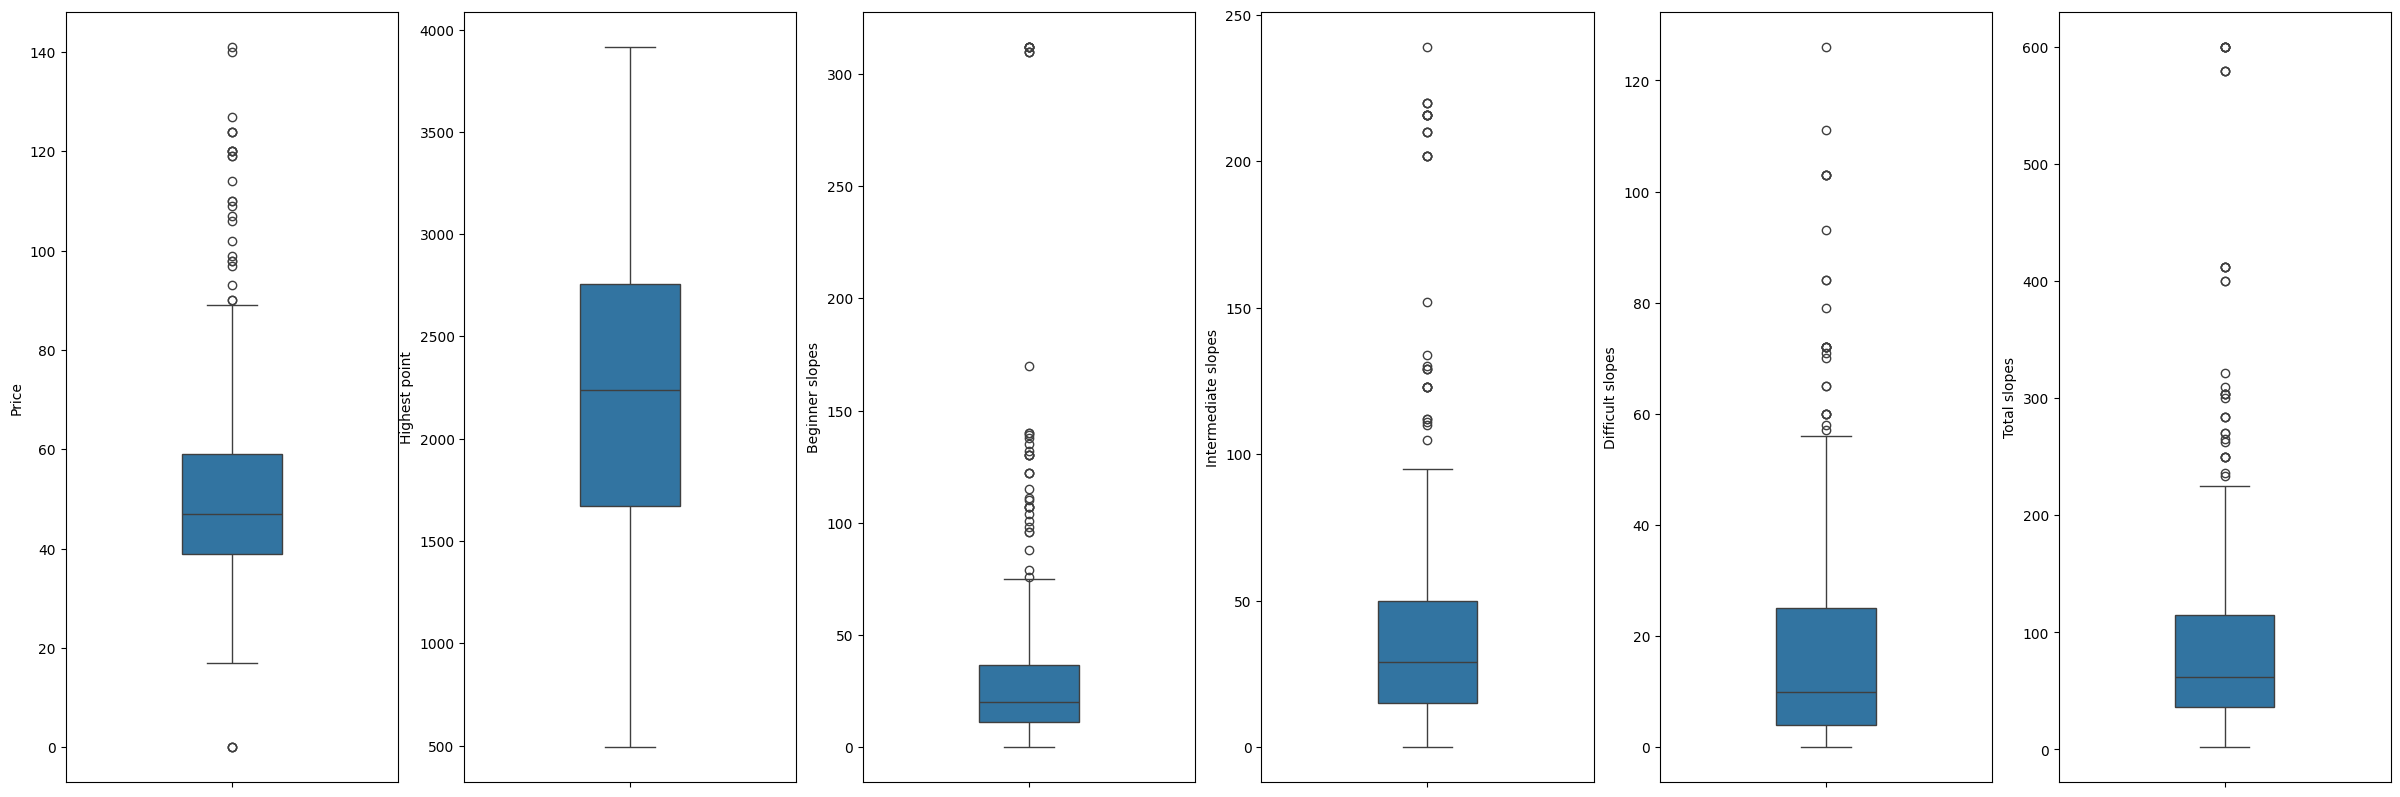

In [ ]:
name = df.columns

fig1, axes1 = plt.subplots(1, 6, figsize=(30,10))
for i in range(6):
    sns.boxplot(df[name[i]], ax=axes1[i], width=0.3)

In [ ]:
# 0 price drop
df.drop(df[df['Price'] == 0].index, inplace=True)

# тотал слопсы больше нуля только оставить
df.drop(df[df['Total slopes'] <= 0].index, inplace=True)

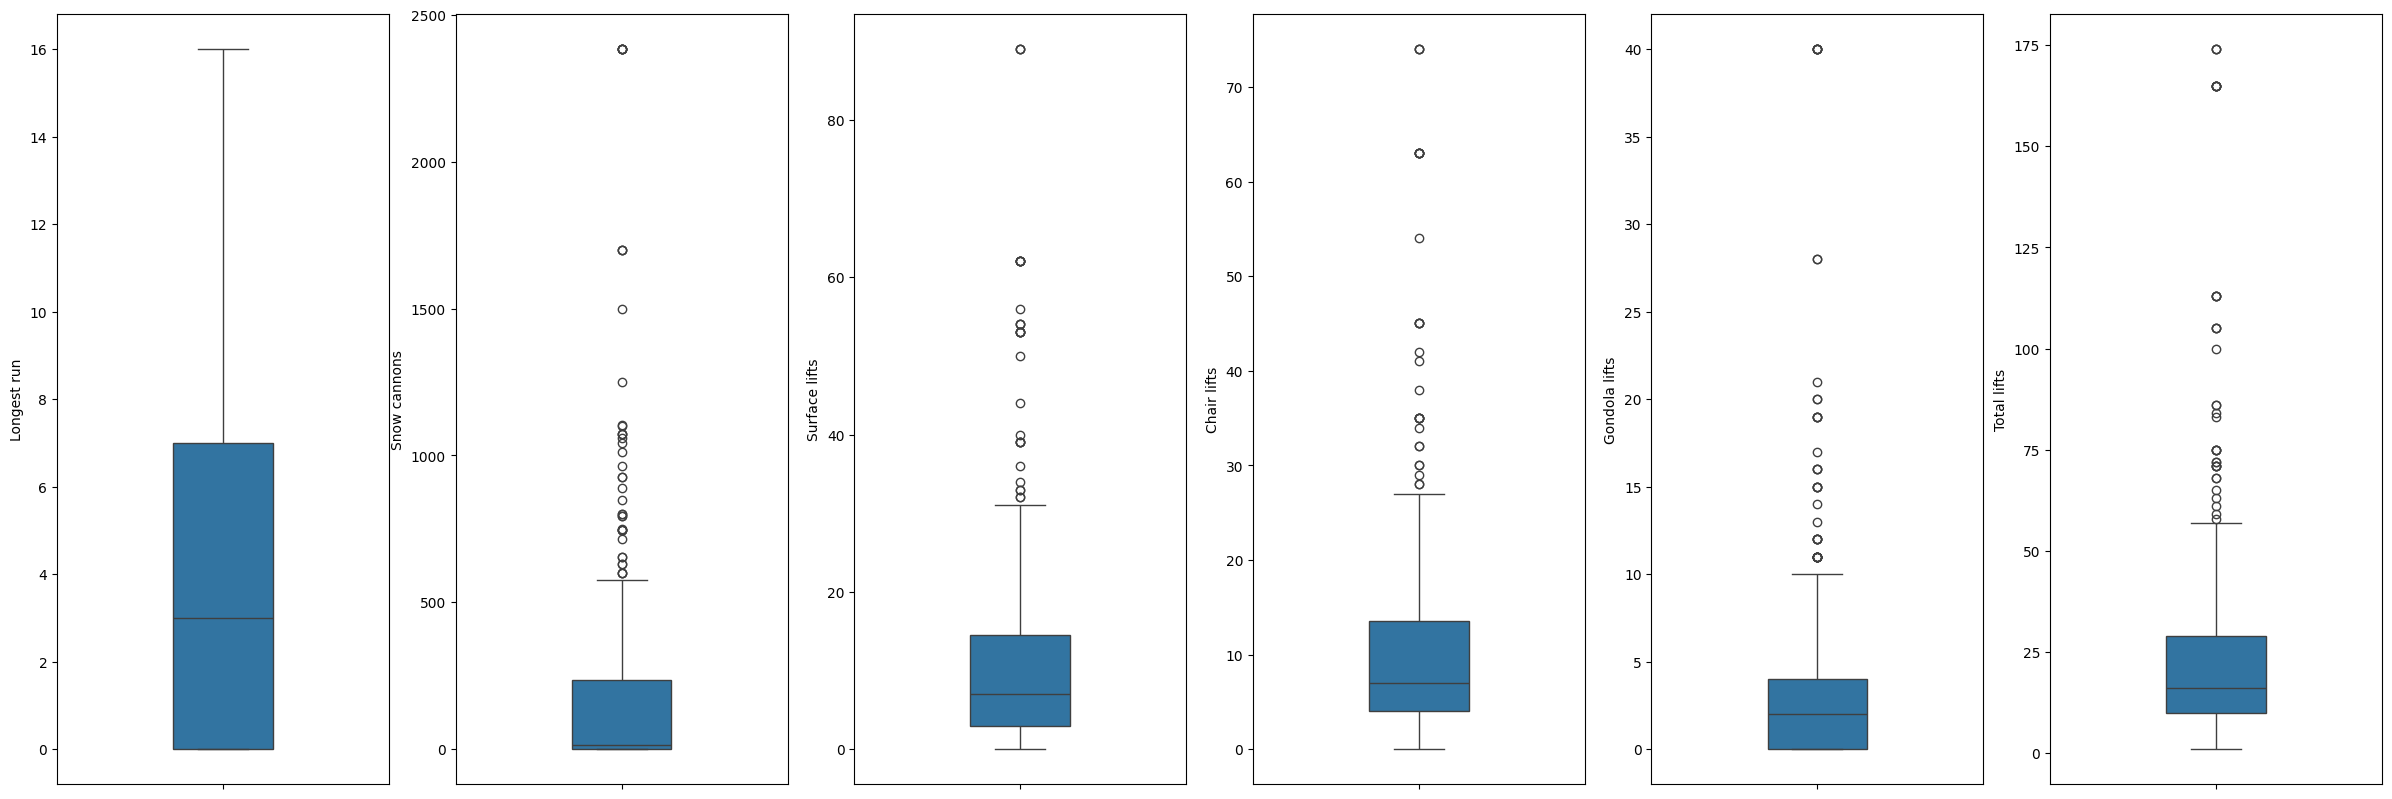

In [ ]:
fig2, axes2 = plt.subplots(1, 6, figsize=(30,10))
for i in range(6, 12):
    sns.boxplot(df[name[i]], ax=axes2[i-6], width=0.3)

In [ ]:
# # лонгет ран весь столбец убираем
# df.drop(columns=["Longest run"], inplace=True)
df.drop(df[df['Longest run'] == 0].index, inplace=True)

# # тотал лифс > 0 оставить
df.drop(df[df['Total lifts'] <= 0].index, inplace=True)

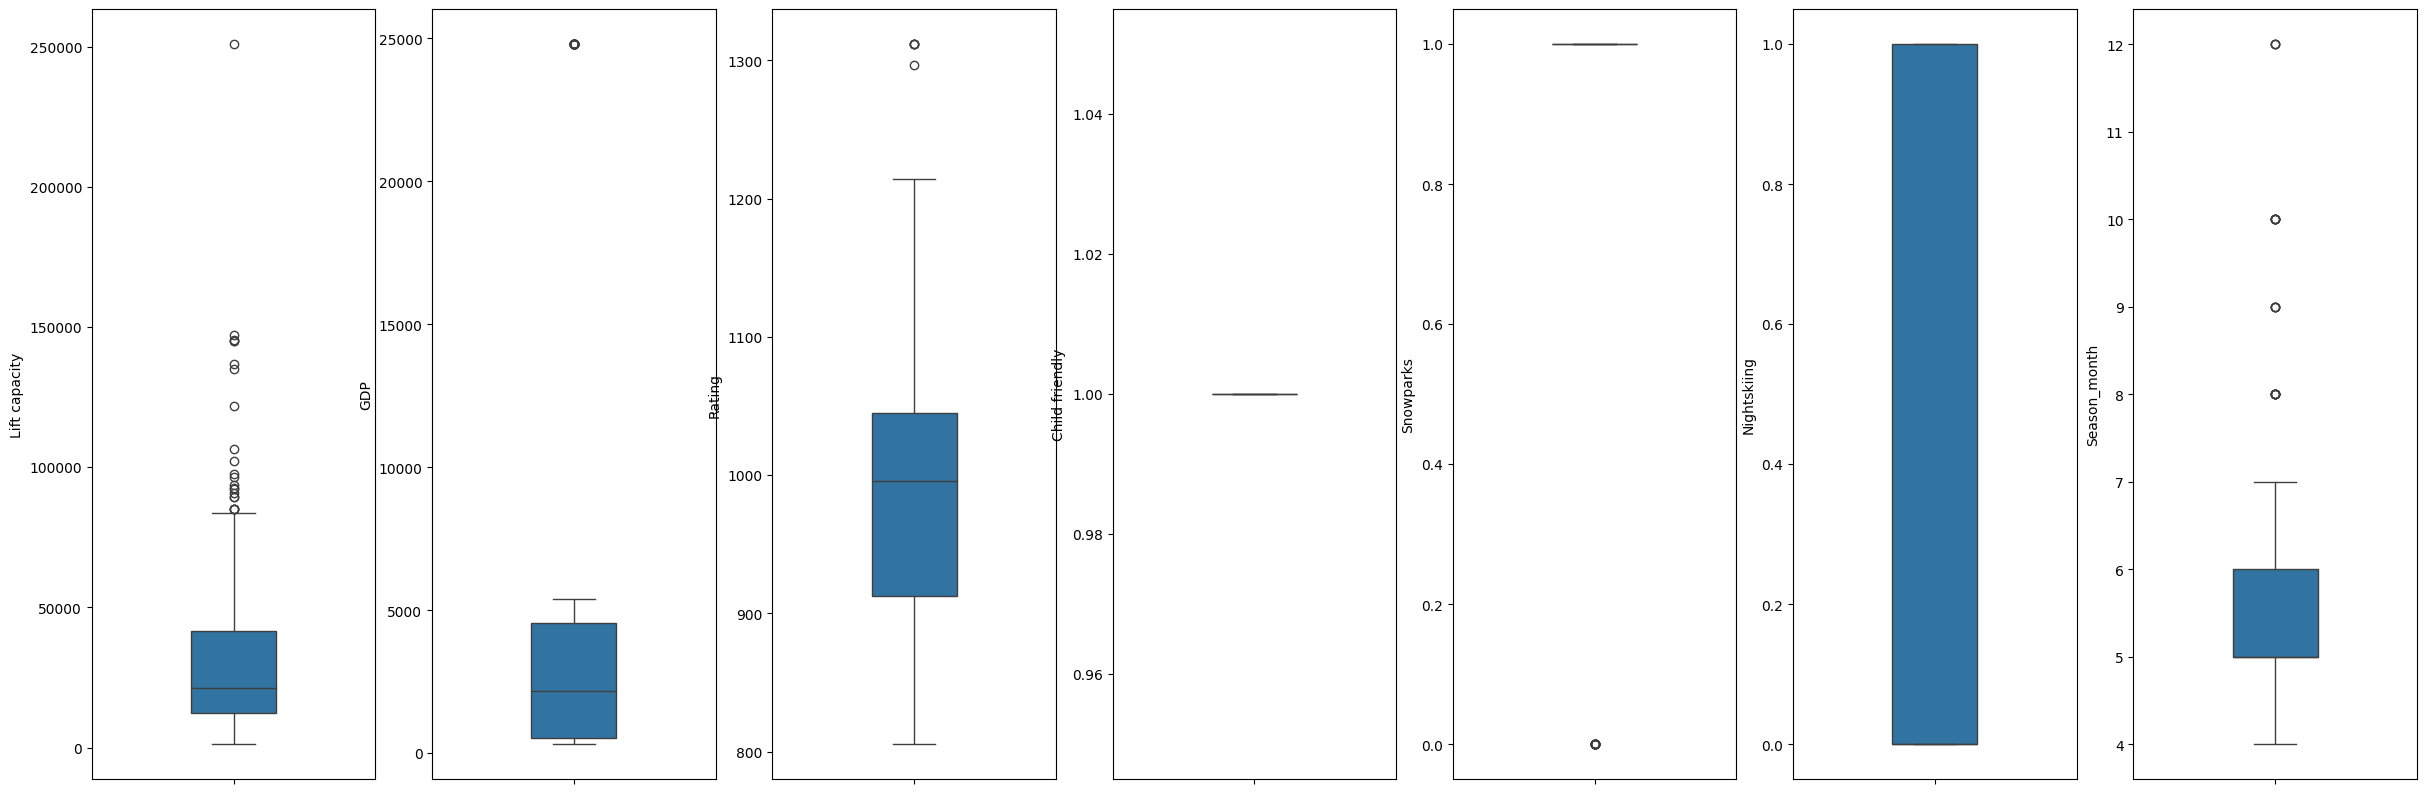

In [ ]:
fig3, axes3 = plt.subplots(1, 7, figsize=(30,10))
for i in range(12, 19):
    sns.boxplot(df[name[i]], ax=axes3[i-12], width=0.3)

In [ ]:
# лифт капасити больше нуля оставить
df.drop(df[df['Lift capacity'] <= 0].index, inplace=True)

# вычесть из каждого значения в столбце рейтинг минимальное значение рейтинга
df_rating_min = df["Rating"].min()
df["Rating"] = df["Rating"] - df_rating_min

In [ ]:
print(df["GDP"].min()) # Finland
print(df["GDP"].max()) # United States

314.538
24796.08


In [ ]:
# очень много 1 и только в одной строке 0
df.drop(columns = ['Child friendly'], inplace=True)

## 2. Построение матрицы корреляций
В результате получаем матрицу по 18 признакам и таргетной переменной - цена.

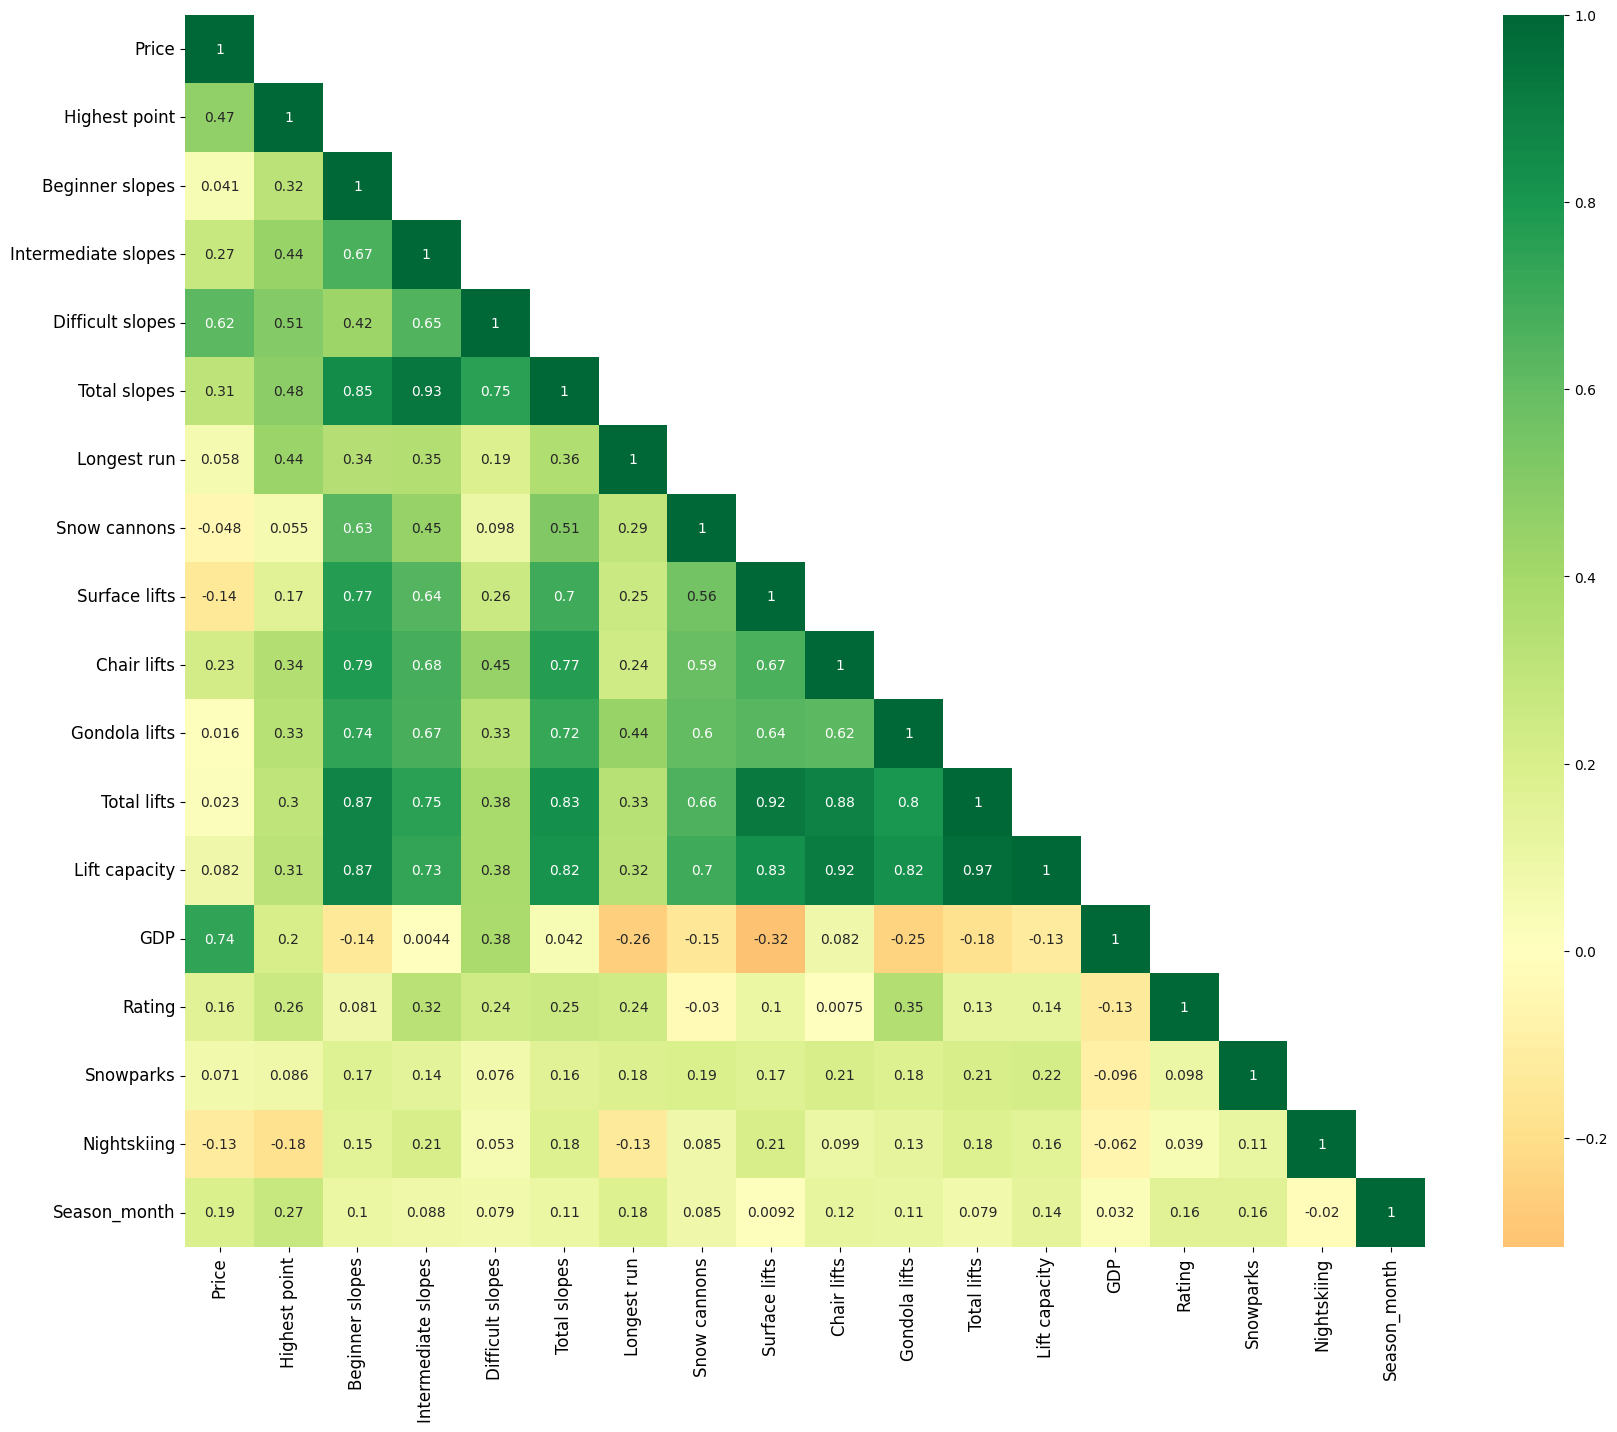

In [ ]:
plt.figure(figsize=(20,16))
corr_matrix = df.corr()
# скрытие верхней части матрицы
mask = np.triu(np.ones_like(corr_matrix, dtype=bool),k=1)
sns.heatmap(corr_matrix, mask=mask, cmap='RdYlGn', center=0,
            annot=True, xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
first_column = corr_matrix.iloc[:, 0]
sorted_first_column = first_column.sort_values(ascending=False)

print(sorted_first_column)

Price                  1.000000
GDP                    0.741700
Difficult slopes       0.624111
Highest point          0.468854
Total slopes           0.310340
Intermediate slopes    0.272772
Chair lifts            0.225116
Season_month           0.190081
Rating                 0.162057
Lift capacity          0.082070
Snowparks              0.070935
Longest run            0.057791
Beginner slopes        0.041391
Total lifts            0.022637
Gondola lifts          0.016121
Snow cannons          -0.048058
Nightskiing           -0.126459
Surface lifts         -0.143457
Name: Price, dtype: float64


## 3. Удаляем факторы, которые визуально не значимы
Удаляем факторы, которые визуально не значимы: Начинающие склоны, Снежные пушки, Буксировочные подъемники, Кресельные подъемники, Подъемники-гондолы, Всего подъемников, Пропускная способность подъемников, Подходит для детей, Сноупарки, Ночные катания.
Получаем матрицу корреляций по значимым факторам:


In [ ]:
columns_drop_02 = []

for i in df.columns:
  if corr_matrix.loc[target_col, i] < 0.2:
    columns_drop_02.append(i)

columns_drop_02

['Beginner slopes',
 'Longest run',
 'Snow cannons',
 'Surface lifts',
 'Gondola lifts',
 'Total lifts',
 'Lift capacity',
 'Rating',
 'Snowparks',
 'Nightskiing',
 'Season_month']

In [ ]:
df.drop(columns=columns_drop_02, inplace = True)

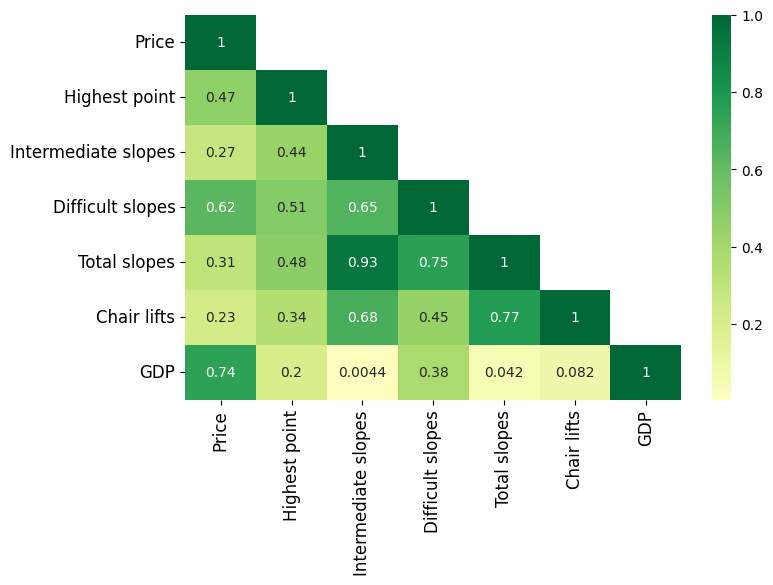

In [ ]:
plt.figure(figsize=(8,5))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool),k=1)
sns.heatmap(corr_matrix, mask=mask, cmap='RdYlGn', center=0,
            annot=True, xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# коллинераны (корр >= 0.7):

# Total slopes и Intermediate slopes
# Total slopes и Difficult slopes

# Chair lifts и Total slopes

## ЧКК

Коэффициент частной корреляции z с x, если y закреплен в модели

$[ r_{zx / y} = \frac{r_{zx} - r_{xy} \cdot r_{zy}}{\sqrt{(1 - r_{zx}^2)(1 - r_{xy}^2)}} ]$

Для каждого фактора “фиксируем” его в модели и перебираем оставшиеся факторы, считая частные коэффициенты.
Рассчитываем матрицу корреляций для r
$r_{zx \cdot y} - r_{zx}$


In [ ]:
def r_zxi_xj(r_zxi, r_xixj, r_zxj):
  return (r_zxi - r_xixj*r_zxj) / ((1-r_zxj**2) * (1-r_xixj**2))**0.5

In [ ]:
# r_z_xi_xj
# xi - фикс
# xj - меняем

df_corr = df.drop(columns=[target_col])
delta_matrix = pd.DataFrame(index=df_corr.columns, columns=df_corr.columns)

for i in df_corr.columns:
  # print(f"Фиксируем  {i}:")
  delta_count = 0
  delta_sum = 0
  r_z_xi = corr_matrix.loc[target_col, i]
  for j in df_corr.columns:
    if i != j:
      r_z_xj = corr_matrix.loc[target_col, j]
      r_z_xi = corr_matrix.loc[target_col, i]
      r_xi_xj = corr_matrix.loc[i, j]

      # корреляция price и j при фиксированном i
      New_Corr = r_zxi_xj(r_z_xi, r_xi_xj, r_z_xj)

      delta = abs(r_z_xi - New_Corr)
      delta_sum += delta

      delta_matrix.loc[i, j] = delta
    delta_matrix.loc[i, i] = 0

delta_matrix = delta_matrix.apply(pd.to_numeric, errors='coerce')

# delta_matrix
# слева -  то что фикс
# названия столбцов = изменяемые переменные

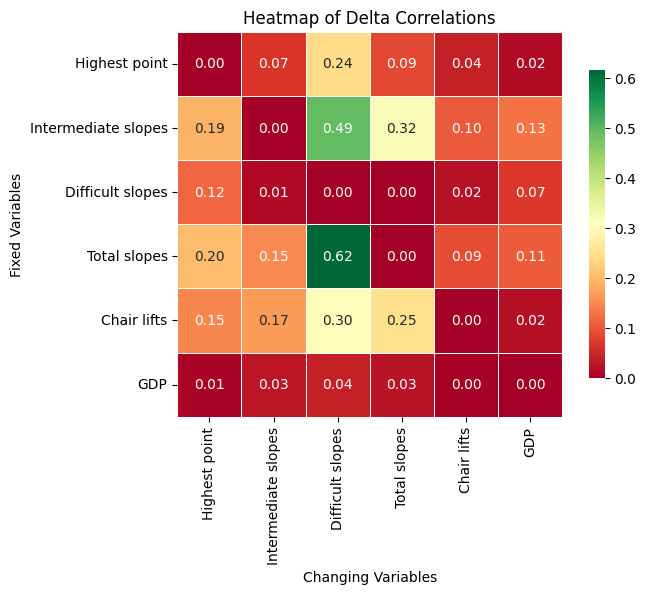

In [ ]:
plt.figure(figsize=(7, 5))

sns.heatmap(delta_matrix, annot=True, fmt=".2f", cmap='RdYlGn', square=True,
            cbar_kws={"shrink": .8}, linewidths=.5)

plt.title('Heatmap of Delta Correlations')
plt.xlabel('Changing Variables')
plt.ylabel('Fixed Variables')
plt.show()

После чего отбираем факторы. \
Отбор трасс: \
Поскольку у нас большая зависимость между разными типами трасс (например, трассами для новичков, среднего уровня и сложными), мы выбираем только одну переменную, которая наиболее полно отражает их общее влияние. В данном случае выбрана переменная Total slopes, так как она агрегирует общую длину всех трасс и имеет наибольшее влияние по корреляциям по сравнению с другими.
Из модели исключаем переменные Intermediate slopes и Difficult slopes, так как их влияние перекрывается переменной **Total slopes**. \

Отбор независимых факторов: \
Теперь мы выбираем факторы, которые менее зависимы друг от друга и способны дополнительно объяснять целевую переменную. На этом этапе:  \
Переменная **Highest point** (высота самой высокой точки курорта) имеет заметную старую корреляцию с Price (0.38), а также новые корреляции (с учётом уже выбранных факторов) остаются значительными. Поэтому включаем её в модель. \

Переменная **Longest run** (длина самой длинной трассы) имеет слабую корреляцию с Price в старой модели (0.21), однако её новые корреляции тоже остаются достаточно высокими. Решено включить её в модель.

Добавление **экономического показателя** (GDP): \
Включаем в модель переменную GDP (валовый внутренний продукт региона), так как она демонстрирует высокий коэффициент корреляции с Price в сравнении с другими факторами. \

Итог: в модель входят Total slopes, Highest point,  Longestrun и GDP, так как они имеют либо сильную связь с целевой переменной (Price), либо дополняют модель за счёт новых независимых связей.

In [ ]:
# большая дельта - наиб влияние - берем
# слопсы и лифт зависимы - выбираем по новым корреляциям
# => Total slopes - относительно других

# df.drop(columns=["Intermediate slopes", "Difficult slopes", "Chair lifts"],inplace=True)

# осталались
# Total slopes
# Highest point
# GDP

In [ ]:
df_columns = ['Price', 'Total slopes', 'GDP', 'Highest point']
DF = df[df_columns]

## 5. Строим модель линейной регрессии
вида $z = b0 + b1*x1 + b2*x2 + b3*x3$ с помощью библиотеки sklearn

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
X = DF.drop(columns=target_col)
y = DF[target_col]

In [ ]:
std = StandardScaler()

X_std = std.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

Считаем коэффициент детерминации модели: $R^2 = 0.694$, где
$R^2 = \frac{Q_\text{регр}}{Q_\text{общ}}$

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_all = r2_score(y_test, y_pred)
print(f"{r2_all:.2f}")

0.69


## Оценка остатков

Остаток $((e_i))$ для $(i)$-го наблюдения определяется как: $[ e_i = y_i - \hat{y}_i ]$ где: \
$(y_i)$ — фактическое значение целевой переменной, \
$(\hat{y}_i)$ — предсказанное значение целевой переменной на основе модели. \
Построили график остатков и гистограмму остатков. \
Гистограмма остатков помогает проверить, соответствуют ли остатки нормальному распределению - в нашем случае соответствуют. \
Q-Q график (график квантилей) - точки практически лежат на прямой, следовательно, остатки распределены нормально. \
Дисперсия остатков (гомоскедастичность): \
Остатки должны иметь постоянную дисперсию $(\text{Var}(e_i) = \sigma^2)$.
Для проверки гомоскедастичности применяем тесты, такие как: \
Тест Бреуша-Пагана, \
Тест Уайта.


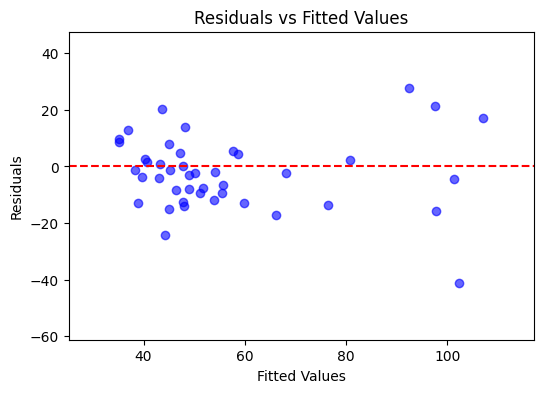

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, color='blue', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')

# Установка пределов по осям
plt.xlim([min(y_pred)-10, max(y_pred)+10])
plt.ylim([min(residuals)-20, max(residuals)+20])

plt.show()

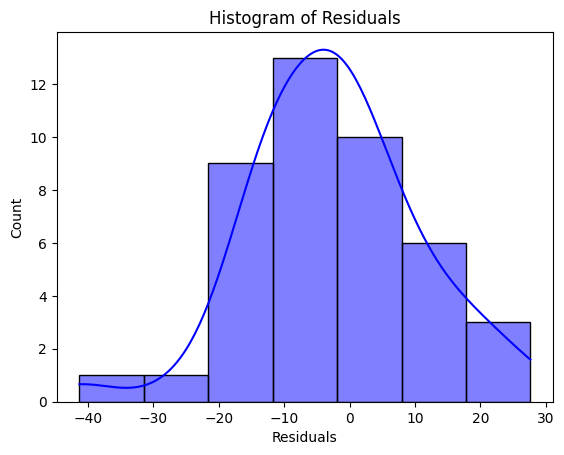

In [ ]:
import statsmodels.api as sm

# Гистограмма остатков по правилу Стерджеса
n = len(residuals)
k = int(np.ceil(np.log2(n) + 1))

sns.histplot(residuals, bins=k, kde=True, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.show()

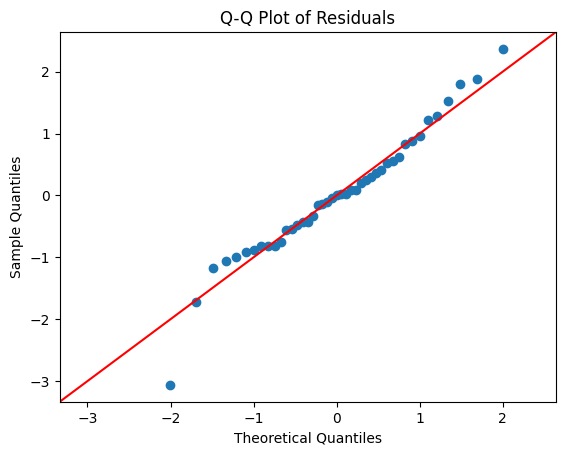

In [ ]:
# Q-Q plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# F_|_S
# S_|_F

## Проверка условий Гаусса

Условия Гаусса-Маркова:
Среднее: $[ \mathbb{E}[\varepsilon_i] = 0 ]$
Дисперсия: $[ \text{Var}(\varepsilon_i) = \sigma^2 ]$
Отсутствие корреляции: $[ \text{Cov}(\varepsilon_i, \varepsilon_j) = 0, ; i \neq j ]$
Нормальное распределение


In [ ]:
# ГАУСС

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

X_with_const = X_test
X_with_const["const"]= 1

# Тест Бройша-Пагана
bp_test = het_breuschpagan(residuals, X_with_const)
print(f"Breusch-Pagan test p-value: {bp_test[1]:.3f}")
# p-value < 0.05 указывает на наличие гетероскедастичности

Breusch-Pagan test p-value: 0.003


In [ ]:
# Тест на нормальность остатков (Shapiro-Wilk)
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {shapiro_test.pvalue:.2f}")
# нормальное больше 0.05

# про автокорреляцию убрала тк у нас нет зависимости со временем

Shapiro-Wilk test p-value: 0.44


## Проверка значимости модели в целом - Фишер

#### Постановка гипотез
Нулевая гипотеза $(H_0)$: Все коэффициенты модели кроме константы равны нулю $(\beta_1 = \beta_2 = \dots = \beta_k = 0)$. \
Т.е. зависимость между зависимой переменной $(y)$ и независимыми переменными $(x_1, x_2, \dots, x_k)$ отсутствует. \

Альтернативная гипотеза $(H_1)$: Хотя бы один из коэффициентов $(\beta_i)((i \geq 1)) $значимо отличается от нуля. \
Т.е. модель объясняет вариацию $(y)$ лучше, чем просто среднее значение.
#### Формула F-статистики:
$F = \frac{\frac{R^2}{p-1}}{\frac{1-R^2}{n - p}}$ \

F - расчетная: 45.36 \
F - критическая: 3.23 \
Модель значима на уровне значимости 0.05 \


In [ ]:
from scipy.stats import f

alpha = 0.05
n = len(y_test)
p = X.shape[1]
r2 = r2_all

In [ ]:
F_r = ((n-p)/(p-1)) * (r2/(1-r2))
F_critical = f.ppf(1-alpha, p-1, n-p)

print(f"F - расчетная: {F_r:.2f}\nF - критическая: {F_critical:.2f}\n")

if (F_r > F_critical): print("Модель значима") #H0 отвергаем (H0: r2=0)
else: print("Модель не значима")

print(f"на уровне значимости {alpha:.2f}")

F - расчетная: 45.36
F - критическая: 3.23

Модель значима
на уровне значимости 0.05


## Проверка значимости коэффициентов по Стьюденту

Выдвижение гипотез для каждого коэффициента (b_i):

Нулевая гипотеза ((H_0)): (b_i = 0) (независимая переменная (X_i) не влияет на зависимую переменную (Y)),
Альтернативная гипотеза ((H_1)): (b_i \neq 0) (независимая переменная (X_i) имеет статистически значимое влияние).
Вычисление t-статистики: Используем формулу: $t_i = \frac{b_i - b_{0i}}{SE(b_i)} $

Определение критического значения или p-value:

Критическое значение (t_{\text{crit}}) берётся из таблицы распределения Стьюдента для заданного уровня значимости ((\alpha), например, (0.05)) и соответствующего числа степеней свободы: [ df = n - k - 1 ] где (n) — число наблюдений, (k) — число предикторов (независимых переменных).
Либо используйте p-value, которое рассчитывается на основе t-распределения.
Принятие решения:

Если $(|t_i| > t_{\text{crit}})$ или p-value (< \alpha): отвергаем нулевую гипотезу ((H_0)), коэффициент (b_i) статистически значим.
Если $(|t_i| \leq t_{\text{crit}})$ или p-value (\geq \alpha): нулевая гипотеза ((H_0)) не отвергается, коэффициент (b_i) считается незначимым.
$(|t_{расч}| > t_{\text{крит}})$

$ \hat{B} = (X^T X)^{-1} X^TZ $

In [ ]:
intercept = model.intercept_
print(f"b0: {intercept:.2f}")

coefficients = model.coef_
for i in range(len(coefficients)):
  print(f"b{i+1}: {coefficients[i]:.2f}")

b0: 57.27
b1: 3.35
b2: 15.98
b3: 6.53


In [ ]:
mse = np.mean(residuals**2)

# Вычисление стандартных ошибок коэффициентов
n = X_test.shape[0]  # Количество наблюдений
p = X_test.shape[1]  # Количество предикторов

# Ковариационная матрица
cov_matrix = mse * np.linalg.inv(X_test.T @ X_test)

# Стандартные ошибки коэффициентов
standard_errors = np.sqrt(np.diagonal(cov_matrix))

# Вычисление t-статистик
t_values = model.coef_ / standard_errors[1:]  # [1:] чтобы исключить свободный член

# Вычисление p-values (двусторонний тест)
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df=n - p - 1)) for t in t_values]

# Уровень значимости
alpha = 0.05

# Вывод результатов и проверка значимости
coefficients = model.coef_
for i in range(len(coefficients)):
  print(f"b{i+1}: {coefficients[i]:.2f}")

print("\nСтандартные ошибки:")
for i in range(1, len(standard_errors)):
  print(f"{standard_errors[i]:.2f}")

print("\nt-статистики для коэффициентов модели:")
for i in range(len(t_values)):
  print(f"{t_values[i]:.2f}")

print("\np-value для коэффициентов модели:")
print(f"{p_values[0]:.2f}")
print(f"{p_values[1]:.8f}")
print(f"{p_values[2]:.3f}")

factor_names = X_train.columns

print("\nИнтерпретация значимости коэффициентов:")
for i, (p_value, factor_name) in enumerate(zip(p_values, factor_names)):
    if p_value < alpha:
      if i == 1:
        print(f"Коэффициент {factor_name} статистически значим (p-value = {p_value:.8f})")
      if i == 2:
        print(f"Коэффициент {factor_name} статистически значим (p-value = {p_value:.3f})")
    else:
        print(f"Коэффициент {factor_name} не статистически значим (p-value = {p_value:.2f})")

b1: 3.35
b2: 15.98
b3: 6.53

Стандартные ошибки:
2.08
2.32
1.98

t-статистики для коэффициентов модели:
1.61
6.90
3.30

p-value для коэффициентов модели:
0.12
0.00000003
0.002

Интерпретация значимости коэффициентов:
Коэффициент Total slopes не статистически значим (p-value = 0.12)
Коэффициент GDP статистически значим (p-value = 0.00000003)
Коэффициент Highest point статистически значим (p-value = 0.002)
